In [1]:
import tensorflow as tf
import os
from os.path import isfile, join
import numpy as np
import shutil
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import subprocess

Copy dataset to arrange audio and noise in different folders

In [2]:
!cp -r "../input/speaker-recognition-dataset" ./

Get the data directories

In [3]:

data_directory = "./speaker-recognition-dataset/16000_pcm_speeches"
audio_folder = "audio"
noise_folder = "noise"

audio_path = os.path.join(data_directory, audio_folder)
noise_path = os.path.join(data_directory, noise_folder)

In [4]:
audio_path

'./speaker-recognition-dataset/16000_pcm_speeches/audio'

set all the parameters for training and other purposes

In [5]:
valid_split = 0.1

shuffle_seed = 43

sample_rate = 16000

scale = 0.5

batch_size = 128

epochs = 15

arrange audio and noise

In [6]:
for folder in os.listdir(data_directory):
    if os.path.isdir(os.path.join(data_directory, folder)):
        if folder in [audio_folder, noise_folder]:
            
            continue
        elif folder in ["other", "_background_noise_"]:
            
            shutil.move(
                os.path.join(data_directory, folder),
                os.path.join(noise_path, folder),
            )
        else:
            shutil.move(
                os.path.join(data_directory, folder),
                os.path.join(audio_path, folder),
            )


Get the list of all noise files

In [7]:

noise_paths = []
for subdir in os.listdir(noise_path):
    subdir_path = Path(noise_path) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

In [8]:
noise_paths

['speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/running_tap.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/dude_miaowing.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/_background_noise_/doing_the_dishes.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/other/exercise_bike.wav',
 'speaker-recognition-dataset/16000_pcm_speeches/noise/other/pink_noise.wav']

**Split noise into chunks of 16,000 steps each**

In [9]:
command = (
    "for dir in `ls -1 " + noise_path + "`; do "
    "for file in `ls -1 " + noise_path + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

In [10]:
os.system(command)
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == sample_rate:
        slices = int(sample.shape[0] / sample_rate)
        sample = tf.split(sample[: slices * sample_rate], slices)
        return sample
    else:
        print("Sampling rate for",path, "is incorrect")
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

**DATASET GENERATION**

In [11]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [12]:
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, sample_rate)
    return audio

**add noise to dataset**

In [13]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio

In [14]:
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [15]:

class_names = os.listdir(audio_path)
print(class_names,)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Speaker:",(name))
    dir_path = Path(audio_path) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

['Benjamin_Netanyau', 'Nelson_Mandela', 'Magaret_Tarcher', 'Julia_Gillard', 'Jens_Stoltenberg']
Speaker: Benjamin_Netanyau
Speaker: Nelson_Mandela
Speaker: Magaret_Tarcher
Speaker: Julia_Gillard
Speaker: Jens_Stoltenberg


In [16]:
# Shuffle to generate random data
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(audio_paths)
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(labels)

In [17]:
# Split into training and validation
num_val_samples = int(valid_split * len(audio_paths))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]


valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

In [18]:
# Create datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=shuffle_seed).batch(32)

**feature Extraction**

In [19]:
# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=scale), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

**Model**

In [20]:
from tensorflow.keras.layers import Conv1D

In [21]:
def residual_block(x, filters, conv_num = 3, activation = "relu"):
    s = keras.layers.Conv1D(filters, 1, padding = "same")(x)
    
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
        x = keras.layers.Activation(activation)(x)
    
    x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    
    return keras.layers.MaxPool1D(pool_size = 2, strides = 2)(x)

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape = input_shape, name = "input")
    
    x = residual_block(inputs, 16, 2)
    x = residual_block(inputs, 32, 2)
    x = residual_block(inputs, 64, 3)
    x = residual_block(inputs, 128, 3)
    x = residual_block(inputs, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    
    outputs = keras.layers.Dense(num_classes, activation = "softmax", name = "output")(x)
    
    return keras.models.Model(inputs = inputs, outputs = outputs)

model = build_model((sample_rate // 2, 1), len(class_names))

model.summary()

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 

model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 8000, 128)    512         input[0][0]                      
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 8000, 128)    0           conv1d_15[0][0]                  
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 8000, 128)    49280       activation_10[0][0]              
______________________________________________________________________________________________

**Training**

In [22]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/15
53/53 [==============================] - 48s 667ms/step - loss: 20.4844 - accuracy: 0.5629 - val_loss: 0.4759 - val_accuracy: 0.8400


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
53/53 [==============================] - 37s 660ms/step - loss: 0.2818 - accuracy: 0.9046 - val_loss: 0.2009 - val_accuracy: 0.9227
Epoch 3/15
53/53 [==============================] - 37s 654ms/step - loss: 0.1648 - accuracy: 0.9378 - val_loss: 0.1238 - val_accuracy: 0.9507
Epoch 4/15
53/53 [==============================] - 37s 652ms/step - loss: 0.1451 - accuracy: 0.9430 - val_loss: 0.1235 - val_accuracy: 0.9573
Epoch 5/15
53/53 [==============================] - 37s 661ms/step - loss: 0.0892 - accuracy: 0.9692 - val_loss: 0.0658 - val_accuracy: 0.9827
Epoch 6/15
53/53 [==============================] - 37s 651ms/step - loss: 0.0825 - accuracy: 0.9699 - val_loss: 0.1130 - val_accuracy: 0.9560
Epoch 7/15
53/53 [==============================] - 37s 656ms/step - loss: 0.0650 - accuracy: 0.9754 - val_loss: 0.0546 - val_accuracy: 0.9787
Epoch 8/15
53/53 [==============================] - 36s 649ms/step - loss: 0.0653 - accuracy: 0.9754 - val_loss: 0.0914 - val_accuracy: 0.9693

**Accuracy**

In [23]:
print("Accuracy of model:",model.evaluate(valid_ds))

24/24 [==============================] - 4s 125ms/step - loss: 0.0480 - accuracy: 0.9827
Accuracy of model: [0.048026569187641144, 0.9826666712760925]


In [24]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

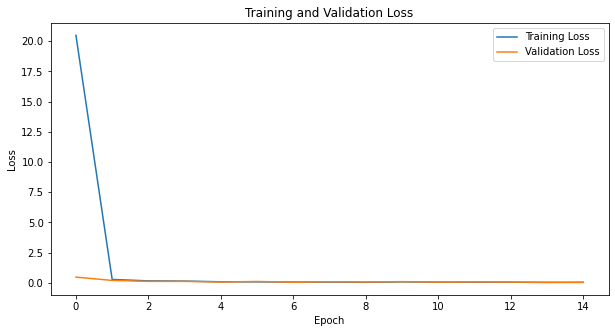

In [25]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in valid_ds:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[153   0   0   0   2]
 [  0 141   0   0   0]
 [  2   0 147   0   3]
 [  3   0   0 144   0]
 [  3   0   0   0 152]]


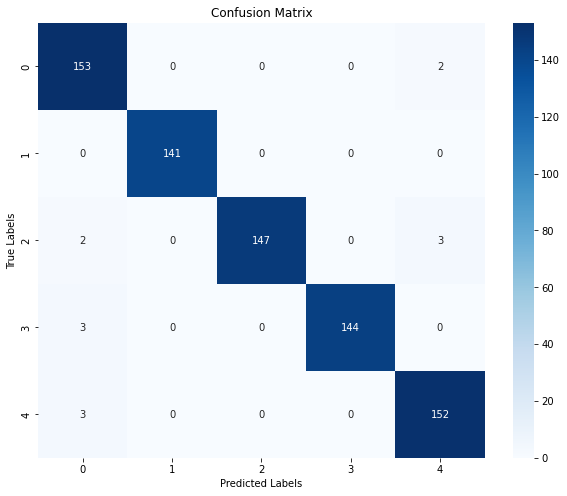

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of classes based on unique labels in true_labels and predicted_labels
num_classes = len(np.unique(true_labels))

# Define class labels
class_labels = [str(i) for i in range(num_classes)]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


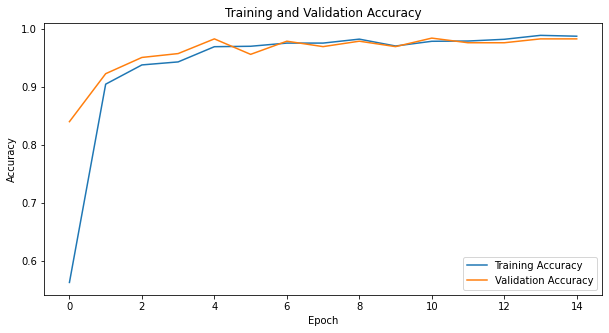

In [28]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Predict**

In [29]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    rnd = np.random.randint(0, batch_size, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index]:
            print("Welcome")
        else:
            print("Sorry")
        print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
The speaker is Nelson_Mandela
Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
The speaker is Nelson_Mandela
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
The speaker is Julia_Gillard
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
The speaker is Magaret_Tarcher
Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
The speaker is Nelson_Mandela
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
The speaker is Benjamin_Netanyau


**Predcit the speaker from the test dataset for real time pred.**

In [30]:
 def paths_to_dataset(audio_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
    test = paths_and_labels_to_dataset(path, labels)


    test = test.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
    )
    test = test.prefetch(tf.data.experimental.AUTOTUNE)


    test = test.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

    for audios, labels in test.take(1):
        ffts = audio_to_fft(audios)
        y_pred = model.predict(ffts)
        rnd = np.random.randint(0, 1, 1)
        audios = audios.numpy()[rnd, :]
        labels = labels.numpy()[rnd]
        y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(1):
            print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
            "[92m",y_pred[index],
                "[92m", y_pred[index]
                )
            )
            
            print("Speaker Predicted:",class_names[y_pred[index]])



In [31]:
path = ["../input/speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/1013.wav"]
labels = ["unknown"]
try:
    predict(path, labels)
except:
    print("Error! Check if the file correctly passed or not!")

Speaker: 4	Predicted: 4
Speaker Predicted: Jens_Stoltenberg
